## Survivor Data Modeling

### Import Dependencies

In [230]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneGroupOut

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import sys
import math
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the path to the survivorData directory
data_dir = os.path.join(current_dir, '..', 'survivorData')

### Read in csv files as Dataframes

In [231]:
# List of CSV file names
csv_files = [
    'advantage_movement.csv',
    'boot_mapping.csv',
    'castaways.csv',
    'castaway_details.csv',
    'challenge_description.csv',
    'challenge_results.csv',
    'confessionals.csv',
    'jury_votes.csv',
    'screen_time.csv',
    'season_palettes.csv',
    'season_summary.csv',
    'survivor_auction.csv',
    'tribe_colours.csv',
    'tribe_mapping.csv',
    'viewers.csv',
    'vote_history.csv'
]

# Create a dictionary to store the DataFrames
dataframes = {}

# Loop through each CSV file and read its data into a DataFrame
for csv_file in csv_files:
    # Specify the relative path to the CSV file
    file_path = os.path.join(data_dir, csv_file)
    
    # Read the data from the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Store the DataFrame in the dictionary
    dataframes[csv_file] = df

### Clean up the data and feature engineer

In [232]:
# Convert tribe_status column to category type
dataframes['tribe_colours.csv']['tribe_status'] = dataframes['tribe_colours.csv']['tribe_status'].astype('category')

# Convert result to a categorical variable
dataframes['castaways.csv']['result'] = pd.Categorical(dataframes['castaways.csv']['result'])
dataframes['castaways.csv']['result'] = dataframes['castaways.csv']['result'].cat.codes

# Merge challenge_results and castaway_details dataframes on castaway_id
castawayAll = pd.merge(dataframes['castaways.csv'], dataframes['castaway_details.csv'], on='castaway_id', how ="left")

castawayAll['genderNumber'] = np.where(castawayAll['gender'] == 'Male', 1,
                                     np.where(castawayAll['gender'] == 'Female', 2,
                                              np.where(castawayAll['gender'] == 'Non-binary', 3, 0)))
castawayAll['won'] = np.where(castawayAll['result'] == 'Sole Survivor', 1, 0)

castawayAll = castawayAll.dropna(subset=['age'])

# Drop rows where 'season' is equal to 44
castawayAll = castawayAll[castawayAll['season'] != 44]

## Predicting Color Values in the survivor dataset: A Comparative Analysis of SVM and Logistic Regression Models

### Introduction:
In this overview, we will delve into the rationale behind predicting color values in a dataset and explore the unique situation it presents when it comes to quantifying results. Specifically, we will compare the performance of Support Vector Machine (SVM) and Logistic Regression models in predicting color values and evaluate the effectiveness of various metrics such as average accuracy, Hamming distance, and Euclidean distance.

### Predicting Color Values in a Dataset:
Color is an essential aspect of visual data analysis and has a wide range of applications, including image processing, computer vision, and data visualization. By predicting color values in a dataset, we can gain insights into patterns, trends, and relationships that are not immediately apparent to the human eye. This predictive modeling approach allows us to develope skills to uncover hidden information and make data-driven decisions.

### Comparison of SVM and Logistic Regression Models:
To determine the best approach for predicting color values, we have chosen to compare the performance of two popular machine learning algorithms: Support Vector Machine (SVM) and Logistic Regression. Both models are widely used in classification tasks and have demonstrated success in various domains.

1. Support Vector Machine (SVM):
SVM is a powerful algorithm that aims to find an optimal hyperplane in a high-dimensional feature space. It separates data points into distinct classes by maximizing the margin between them. SVM is known for its ability to handle complex datasets and nonlinear relationships effectively. Its versatility and robustness make it a suitable candidate for predicting color values in a dataset.

2. Logistic Regression:
Logistic Regression is a probabilistic machine learning algorithm used for binary classification tasks. It models the relationship between the input features and the probability of a particular outcome. Logistic Regression is known for its simplicity, interpretability, and efficiency. While it may not capture complex nonlinear relationships as effectively as SVM, it can still yield accurate predictions in certain scenarios.

### Quantifying Results:
To evaluate the performance of our SVM and Logistic Regression models in predicting color values, we will utilize several metrics that address different aspects of model performance:

1. Average Accuracy:
Average accuracy measures the percentage of correctly classified instances across all classes.

2. Hamming Distance:
Hamming distance quantifies the dissimilarity between two color values by measuring the number of positions at which they differ. Since color values can be represented as vectors in a multi-dimensional space, Hamming distance provides a useful metric for evaluating the similarity or dissimilarity of predicted colors.

3. Euclidean Distance:
Euclidean distance measures the straight-line distance between two points in a multi-dimensional space. In the context of color values, Euclidean distance allows us to determine the proximity of predicted colors to the ground truth. 

### Conclusion:
Predicting color values in a dataset presents a unique situation due to its visual and perceptual nature. By comparing the performance of SVM and Logistic Regression models, we can gain insights into the effectiveness of these algorithms in accurately predicting color values. Furthermore, by utilizing metrics such as average accuracy, Hamming distance, and Euclidean distance, we can comprehensively evaluate the performance of the models and make informed decisions regarding their suitability for color prediction tasks.



## Color prediction with SVM model

In [233]:
# Prepare the data for training
X = dataframes['tribe_colours.csv']['tribe_status'].values.reshape(-1, 1)
y = dataframes['tribe_colours.csv']['tribe_colour']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create an SVM model
svm_model = svm.SVC()

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_svm)

# Calculate Hamming distance for all predictions
hamming_distances = []

for idx in range(len(y_pred)):
    hamming_dist = sum(el1 != el2 for el1, el2 in zip(y_pred[idx], y_test.iloc[idx]))
    hamming_distances.append(hamming_dist)

# Calculate average Hamming distance for incorrect predictions
avg_hamming_distance_svm = np.mean(hamming_distances)

# The Hamming distance measures the dissimilarity between two strings of equal length. In the context of hex color values, 
# each character represents a component of the color (e.g., red, green, and blue), and the Hamming distance calculates 
# the number of positions at which the predicted and actual color values differ.

# Since hex color values consist of six characters (e.g., #RRGGBB), the Hamming distance for hex color values can range from 0 to 6.

# Print average Hamming distance for incorrect predictions
print("Average Hamming Distance for Incorrect Predictions:", avg_hamming_distance_svm)

# Calculate Euclidean distance for color similarity
euclidean_distances = []
for idx in range(len(y_pred)):
    predicted_color = y_pred[idx][1:]  # Remove the "#" character from the predicted color
    actual_color = y_test.iloc[idx][1:]  # Remove the "#" character from the actual color
    
    # Convert hex color values to RGB tuples
    predicted_rgb = tuple(int(predicted_color[i:i+2], 16) for i in (0, 2, 4))
    actual_rgb = tuple(int(actual_color[i:i+2], 16) for i in (0, 2, 4))
    
    # Calculate Euclidean distance between RGB tuples
    distance = math.sqrt(sum((p - a) ** 2 for p, a in zip(predicted_rgb, actual_rgb)))
    euclidean_distances.append(distance)

# Calculate average Euclidean distance for all predictions
avg_euclidean_distance_svm = np.mean(euclidean_distances)

# The Euclidean distance measures the spatial or geometric distance between two colors in the RGB color space.
# In the RGB color space, each color is represented by three components: red (R), green (G), and blue (B). 
# The Euclidean distance calculates the straight-line distance between two colors in this three-dimensional space.

# Print average Euclidean distance for all predictions
print("Average Euclidean Distance for All Predictions:", avg_euclidean_distance_svm)

Accuracy: 0.13043478260869565
Average Hamming Distance for Incorrect Predictions: 4.695652173913044
Average Euclidean Distance for All Predictions: 210.79982279467572


c:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\__init__.py:202: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return array[key] if axis == 0 else array[:, key]


## Color prediction with logistic regression model

In [234]:
# Create a Logistic Regression model
logreg_model = LogisticRegression()

# Train the model
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_test)

# Calculate accuracy
accuracy_logistic_regression = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_logistic_regression)

# Calculate Hamming distance for all predictions
hamming_distances = []

for idx in range(len(y_pred)):
    hamming_dist = sum(el1 != el2 for el1, el2 in zip(y_pred[idx], y_test.iloc[idx]))
    hamming_distances.append(hamming_dist)

# Calculate average Hamming distance for incorrect predictions
avg_hamming_distance_logistic_regression = np.mean(hamming_distances)

# The Hamming distance measures the dissimilarity between two strings of equal length. In the context of hex color values, 
# each character represents a component of the color (e.g., red, green, and blue), and the Hamming distance calculates 
# the number of positions at which the predicted and actual color values differ.

# Since hex color values consist of six characters (e.g., #RRGGBB), the Hamming distance for hex color values can range from 0 to 6.

# Print average Hamming distance for incorrect predictions
print("Average Hamming Distance for Incorrect Predictions:", avg_hamming_distance_logistic_regression)

# Calculate Euclidean distance for color similarity
euclidean_distances = []
for idx in range(len(y_pred)):
    predicted_color = y_pred[idx][1:]  # Remove the "#" character from the predicted color
    actual_color = y_test.iloc[idx][1:]  # Remove the "#" character from the actual color
    
    # Convert hex color values to RGB tuples
    predicted_rgb = tuple(int(predicted_color[i:i+2], 16) for i in (0, 2, 4))
    actual_rgb = tuple(int(actual_color[i:i+2], 16) for i in (0, 2, 4))
    
    # Calculate Euclidean distance between RGB tuples
    distance = math.sqrt(sum((p - a) ** 2 for p, a in zip(predicted_rgb, actual_rgb)))
    euclidean_distances.append(distance)

# Calculate average Euclidean distance for all predictions
avg_euclidean_distance_logistic_regression = np.mean(euclidean_distances)

# The Euclidean distance measures the spatial or geometric distance between two colors in the RGB color space.
# In the RGB color space, each color is represented by three components: red (R), green (G), and blue (B). 
# The Euclidean distance calculates the straight-line distance between two colors in this three-dimensional space.

# Print average Euclidean distance for all predictions
print("Average Euclidean Distance for All Predictions:", avg_euclidean_distance_logistic_regression)

Accuracy: 0.10869565217391304
Average Hamming Distance for Incorrect Predictions: 4.826086956521739
Average Euclidean Distance for All Predictions: 226.73901721688125


c:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## Color prediction model comparision

Upon examining the graph plotted on a logarithmic scale, which enhances the visual representation of metric differences, a notable observation arises: the accuracy of the SVM model surpasses that of the Logistic Regression model by a significant margin. However, when considering the average Hamming distance and average Euclidean distance metrics, the difference between the two models is negligible.

This log scale representation allows for a clearer visualization of the relative differences between the metrics. It accentuates the disparity in accuracy between SVM and Logistic Regression, emphasizing the stronger performance of SVM in terms of overall correct predictions. At the same time, the log scale helps highlight the close proximity of the two models in terms of the average Hamming distance and average Euclidean distance, indicating similar abilities to capture the patterns and relationships within the data.

Therefore, taking into account the log scale representation, the graph reaffirms that SVM excels in accuracy compared to Logistic Regression, while both models demonstrate comparable results in terms of capturing the similarity between predicted and actual values.

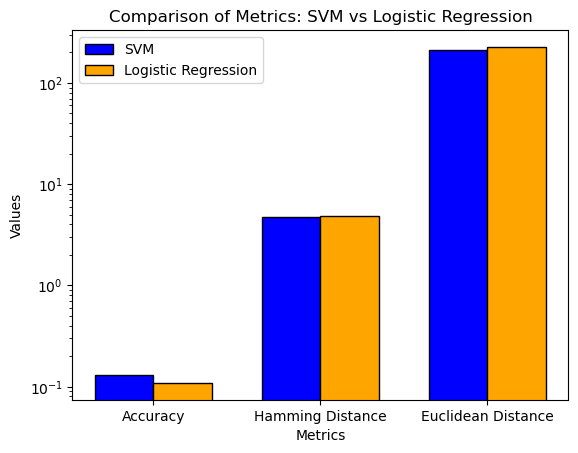

In [235]:
# Define the metrics for SVM
svm_metrics = {
    'Accuracy': accuracy_svm,
    'Hamming Distance': avg_hamming_distance_svm,
    'Euclidean Distance': avg_euclidean_distance_svm
}

# Define the metrics for Logistic Regression
logreg_metrics = {
    'Accuracy': accuracy_logistic_regression,
    'Hamming Distance': avg_hamming_distance_logistic_regression,
    'Euclidean Distance': avg_euclidean_distance_logistic_regression
}

# Create a list of metric names
metrics = list(svm_metrics.keys())

# Create a list of SVM metric values
svm_values = list(svm_metrics.values())

# Create a list of Logistic Regression metric values
logreg_values = list(logreg_metrics.values())

# Set the width of the bars
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = range(len(metrics))
r2 = [x + bar_width for x in r1]

# Create the bar plot
plt.bar(r1, svm_values, color='blue', width=bar_width, edgecolor='black', label='SVM')
plt.bar(r2, logreg_values, color='orange', width=bar_width, edgecolor='black', label='Logistic Regression')

# Add labels, title, and legend
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Metrics: SVM vs Logistic Regression')
plt.xticks([r + bar_width/2 for r in range(len(metrics))], metrics)
plt.legend()

# Set the y-axis scale to logarithmic
plt.yscale('log')

# Display the plot
plt.show()


## Model analysis

### SVM interpretation

The repeated occurrence of '7' as the chosen support vector suggests that instances with this specific feature value hold significant importance in the classification task. The value '7' plays a crucial role in determining the decision boundary between the classes, indicating that instances associated with '7' have distinct characteristics that differentiate them from other data points. These instances strongly influence the SVM model's predictions and contribute significantly to the separation of the classes. Overall, the repeated appearance of '7' as support vectors indicates its relevance and influence in the classification process.

### Logistic regression interpretation

The weight (coefficient) for 'tribe_status' is -0.67694186. In logistic regression, the coefficients represent the impact of each feature on the predicted probability of the target variable.

Since 'tribe_status' is a categorical feature, it likely represents different categories or groups within the data. In this case, the weight of -0.67694186 indicates the effect of each unit change in the 'tribe_status' feature on the log-odds of the target variable.

Specifically, for each unit increase in 'tribe_status', the log-odds of the target variable decrease by approximately 0.67694186. This suggests that higher values of 'tribe_status' are associated with a lower likelihood or probability of the target variable.

In [236]:
# Retrieve the indices of the support vectors
support_vector_indices = svm_model.support_

# Retrieve the support vectors from the training set
support_vectors = X_train[support_vector_indices]

# Print the support vectors
print("Chosen Support Vectors:")
for vector in support_vectors:
    print(vector)

# Retrieve the learned coefficient from the logistic regression model
coefficient = logreg_model.coef_[0]

# Print the weight for the feature
print(f"Weight for 'tribe_status': {coefficient}")

Chosen Support Vectors:
[7]
[7]
[7]
[6]
[6]
[7]
[7]
[7]
[7]
[7]
[6]
[7]
[11]
[7]
[7]
[7]
[7]
[7]
[6]
[11]
[7]
[7]
[7]
[6]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[6]
[7]
[7]
[6]
[7]
[7]
[7]
[7]
[7]
[11]
[7]
[7]
[7]
[11]
[6]
[7]
[7]
[11]
[7]
[7]
[7]
[6]
[6]
[7]
[7]
[7]
[7]
[6]
[7]
[7]
[7]
[6]
[6]
[7]
[6]
[7]
[7]
[7]
[7]
[6]
[6]
[11]
[7]
[7]
[7]
[7]
[6]
[7]
[6]
[7]
[7]
[7]
[5]
[10]
[4]
[3]
[1]
[8]
[2]
[7]
[6]
[7]
[6]
[7]
[11]
[11]
[6]
[7]
[6]
[7]
[7]
[7]
[7]
[7]
[6]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[6]
[7]
[7]
[7]
[6]
[6]
[7]
[6]
[7]
[6]
[7]
[6]
[7]
[7]
[7]
[7]
[7]
[7]
[6]
[7]
[7]
[7]
[6]
[7]
[6]
[7]
[7]
[7]
[6]
[7]
[6]
[7]
[7]
[7]
[7]
[7]
[7]
[6]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[11]
[7]
[7]
[6]
Weight for 'tribe_status': [-0.58625123]


## Simulation of survivor seasons and predicting the order in which people leave the game



In [237]:
def split_dataframe(df, column_name):
    groups = df.groupby(column_name)
    result = [group for _, group in groups]
    return result

# Call split_dataframe on column name "version_season"
season_split = split_dataframe(castawayAll, 'version_season')

for df in season_split:
    df['orderOut'] = range(1, len(df) + 1)

# Perform leave-one-group-out cross-validation
logo = LeaveOneGroupOut()

# Initialize a list to store the predicted outcomes
predicted_outcomes = []

# Create a list to store the true outcomes
true_outcomes = []

# Create a list of group labels corresponding to each DataFrame in season_split
group_labels = [i for i, _ in enumerate(season_split)]

# Initialize the SVM model
model = svm.SVC()

# Iterate through each test set
for train_index, test_index in logo.split(season_split, groups=group_labels):
    # Get the training and test sets for the current iteration
    train_set = [season_split[i] for i in train_index]
    test_set = [season_split[i] for i in test_index]

    # Initialize the SVM model for each iteration
    model = svm.SVC()

# Iterate through each test set
for train_index, test_index in logo.split(season_split, groups=group_labels):
    # Get the training and test sets for the current iteration
    train_set = [season_split[i] for i in train_index]
    test_set = [season_split[i] for i in test_index]

    # Iterate through each test DataFrame
    for i, test_df in enumerate(test_set):
        X_train = pd.concat(train_set)[['age', 'genderNumber']]
        y_train = pd.concat(train_set)['orderOut']

        # Fit the SVM model on the training data
        model.fit(X_train, y_train)

        # Predict the orderOut values for the test set
        X_test = test_df[['age', 'genderNumber']]
        y_pred = model.predict(X_test)

        # Save the predicted outcomes to the list
        predicted_outcomes.extend(y_pred)

        # Save the true outcomes to the list
        true_outcomes.extend(test_df['orderOut'])

        # Remove the row with the lowest orderOut value from the possible choices
        min_orderOut = min(test_df['orderOut'])
        test_set[i] = test_df[test_df['orderOut'] > min_orderOut]

# Print the predicted outcomes
print("Predicted Outcomes:")
print(predicted_outcomes)

# Calculate the accuracy of the predicted outcomes
accuracy = accuracy_score(true_outcomes, predicted_outcomes)
print("Accuracy:", accuracy)

Predicted Outcomes:
[3, 9, 5, 3, 3, 9, 5, 5, 5, 9, 5, 5, 5, 5, 9, 3, 5, 5, 5, 5, 5, 9, 9, 5, 5, 9, 3, 3, 5, 9, 9, 3, 3, 5, 5, 9, 5, 5, 5, 5, 5, 9, 5, 5, 9, 5, 9, 5, 9, 3, 9, 3, 5, 8, 8, 3, 9, 5, 3, 8, 8, 9, 5, 5, 3, 5, 1, 8, 5, 5, 9, 1, 3, 3, 8, 3, 3, 3, 3, 5, 3, 5, 8, 5, 3, 3, 8, 9, 5, 5, 9, 9, 3, 5, 9, 5, 5, 3, 3, 5, 5, 9, 5, 5, 9, 9, 3, 9, 5, 9, 9, 9, 3, 1, 3, 5, 9, 3, 5, 9, 3, 9, 5, 3, 3, 9, 9, 9, 5, 9, 9, 3, 9, 5, 3, 5, 9, 5, 9, 9, 9, 5, 9, 9, 3, 5, 9, 9, 3, 5, 3, 9, 5, 9, 3, 9, 5, 5, 1, 9, 9, 9, 5, 9, 5, 9, 9, 5, 9, 3, 5, 9, 9, 9, 3, 3, 3, 3, 3, 8, 9, 5, 5, 9, 5, 5, 9, 3, 9, 8, 9, 8, 9, 9, 5, 9, 5, 9, 3, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 3, 5, 3, 3, 9, 5, 3, 5, 9, 8, 5, 9, 3, 5, 9, 5, 5, 5, 5, 9, 5, 5, 5, 9, 5, 5, 5, 9, 5, 9, 3, 5, 5, 9, 9, 9, 9, 9, 9, 3, 5, 5, 9, 5, 9, 3, 5, 9, 9, 3, 5, 9, 5, 5, 3, 3, 5, 5, 9, 5, 5, 5, 5, 9, 5, 5, 9, 5, 9, 9, 3, 9, 9, 5, 9, 5, 1, 3, 5, 5, 9, 5, 1, 5, 5, 9, 9, 5, 1, 5, 5, 3, 5, 9, 5, 5, 3, 5, 5, 9, 5, 5, 5, 9, 5, 5, 9, 5, 5, 9, 3, 9, 1